# Understanding Origination and Extinction Rates in Neutral and Species-Level Communities

Before trying to characterize the dynamics of a neutral and non-neutral community using Haar fluctuation analysis and cross-Haar correlations, first understanding it's dynamics in terms of species richness, origination, and extinction will help to build a general expectation of its behaviour through time.

Under Hubbell's original formulation of neutral theory, equilibrium species richness is a function of both speciation rate and community size. For increases in each of the parameters, one can expect a more species rich community. In this regard its important to realize that changes in community species richness, as the process is allowed to drift through time, in no way changes the expected speciation rate, or the expected number of new species per unit time. As such, given a community of fixed size, the expected number of new species to emerge per time step is simply the speciation rate multiplied by the death rate. 

In [1]:
# Set User Paths #
src_path = "../Blind_Review_Code_Repository_2025/src/"

In [2]:
# Library Imports
import os
os.chdir(src_path)

# From src
## UNTB Functions
import untbPython
## Diversity Metric Functions
import analysisFunctions 
import divDynFunctions
import samplingFunctions
import diversityMetrics
## Haar Fluctuation Analysis Functions
import haarFluctuationAnalysis
import crossHaarCorrelation

# Other Imports
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import set_num_threads # Set number of threads for computations
import matplotlib
from scipy.stats import pearsonr

## Simulate UNTB Dynamics

In [3]:
# Simulation Parameters 
num_simulations = 1
J = 500 # Community Size
model_steps = 10000 # Total number of simulation steps
expanded_community = np.repeat(1,J) # Initialize community 

# Parameters
params = np.array(([0.05, 100])) # Parameters for speciation rate and death rate
params = np.expand_dims(params, axis=0) # Expand parameter grid
cutoffs = np.array([2000]) # Set burn-in period

time_v = np.arange(cutoffs[0], model_steps) # Set time vector
tc = analysisFunctions.firstEigen(params[0,1], params[0,0], J) # Estimate characteristic timescale
print(f"Relaxation Time in log-time: {np.round(np.log10(1/tc),2)}; Death Rate: {params[0,1]}; Speciation Rate: {params[0,0]}") # Print model parameters

Relaxation Time in log-time: 2.0; Death Rate: 100.0; Speciation Rate: 0.05


In [4]:
# UNTB Simulation
k = 0
untb_results, ancs, desc, n_muts = untbPython.untb_Hankin_Phylo_V2(expanded_community, mutation_probability= params[k,0], death_rate= int(params[k,1]), generations=model_steps, keep=False)
# Richness
unRich = untbPython.return_richness(untb_results)

In [5]:
# Get Speciation and Extinction Rates (raw unbiased rates)
# Negative Values are Originations
turno = -np.diff(unRich[:,1])  

ext_man = []
ori_man = []

for val in turno:
    if val > 0:
        ori_man.append(val)
        ext_man.append(0)
    else:
        ori_man.append(0)
        ext_man.append(-val)

# Add zero at the start to align with unRich time steps
unOri = np.array([0] + ori_man)
unExt = np.array([0] + ext_man)

In [6]:
# Truncate after characteristic timescale and discard 5 on either end 
unRich = unRich[((cutoffs[k]) + 5):-5,:]
unOri = unOri[(cutoffs[k] + 5):-5]
unExt = unExt[(cutoffs[k]+ 5):-5]
muts = n_muts[(cutoffs[k] + 5):-5]
print(f"Simulation {1}: Richness Lenght = {len(unRich)}, Ori Lenght = {len(unOri)}")

Simulation 1: Richness Lenght = 7990, Ori Lenght = 7990


In [7]:
# Rates of ext/org sorted by richness
v2 = np.array([unRich[:-1,1], unOri[:-1], unExt[:-1], muts[1:]])
richness_values = np.unique(unRich[:,1])

ori_mean_at_richness = []
ext_mean_at_richness = []
muts_mean_at_richness = []
muts_all_at_richness = []
ori_all_at_richness = []
ext_all_at_richness = []

for i in range(len(richness_values)):
    rv = richness_values[i]
    ori_mean_at_richness.append(np.mean(v2[1, v2[0,:] == rv]))
    ext_mean_at_richness.append(np.mean(v2[2, v2[0,:] == rv]))
    muts_mean_at_richness.append(np.mean(v2[3, v2[0,:] == rv]))
    muts_all_at_richness.append(np.array([v2[3, v2[0,:] == rv]]))
    ori_all_at_richness.append(np.array([v2[1, v2[0,:] == rv]]))
    ext_all_at_richness.append(np.array([v2[2, v2[0,:] == rv]]))

oriM2 = [i for i in ori_mean_at_richness]
extM2 = [i for i in ext_mean_at_richness]
mutsM2 = [i for i in muts_mean_at_richness]

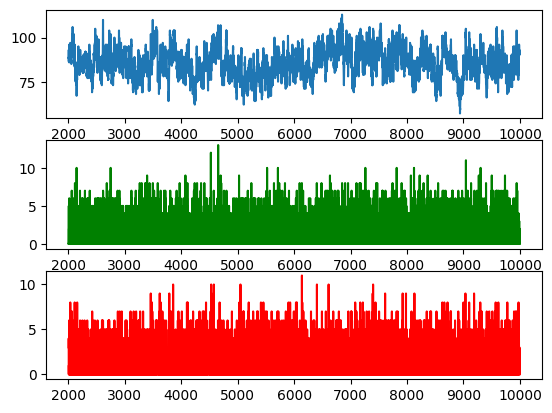

In [8]:
# Plot of raw richness and rates
fig, axs = plt.subplots(3,1)
axs[0].plot(unRich[:,0], unRich[:,1])
axs[1].plot(unRich[:,0], unOri, c = "green")
axs[2].plot(unRich[:,0], unExt, c = "red")

### Plot of rates

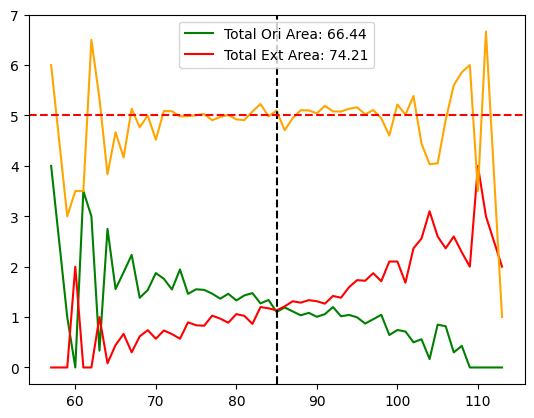

In [9]:
# Plot

oriM2_sum = np.sum(oriM2)
extM2_sum = np.sum(extM2)

plt.plot(richness_values, oriM2, c = "green", label = f"Total Ori Area: {np.round(oriM2_sum,2)}")
plt.plot(richness_values, extM2, c = "red", label = f"Total Ext Area: {np.round(extM2_sum,2)}")
plt.plot(richness_values, mutsM2, c = "orange")
plt.axvline(np.mean(richness_values), c = "black", linestyle = "dashed")
plt.axhline(5, c = "red", linestyle = "dashed")
plt.legend()

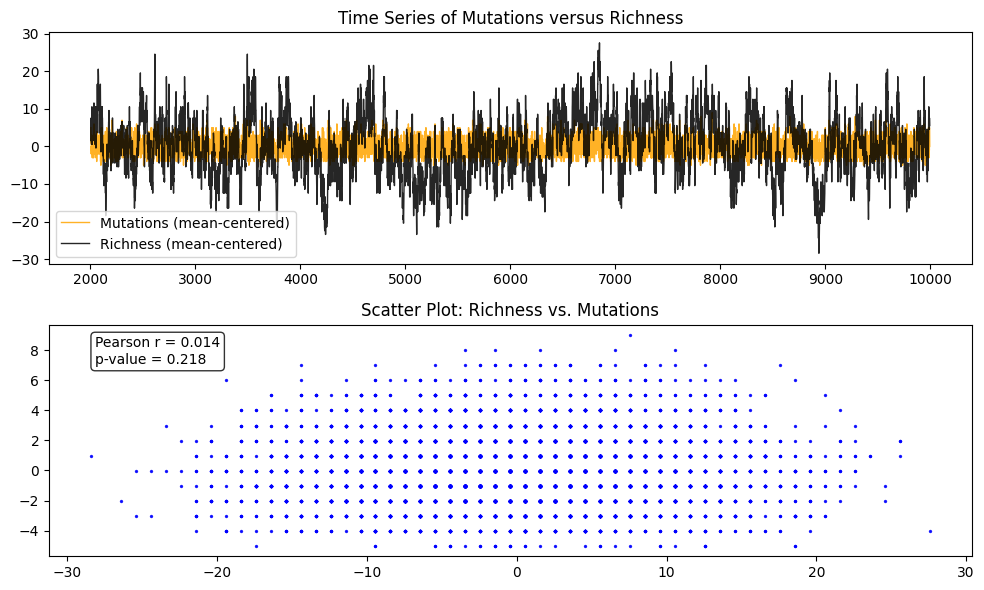

In [10]:
# Plot of actual mutations (species) with sampling intensities
# Not this follows central limit theorm

muts_offset = muts[1:]
unRich_aligned = unRich[:-1, 1]

# Mean-centered
muts_centered = muts_offset - np.mean(muts_offset)
richness_centered = unRich_aligned - np.mean(unRich_aligned)

# Pearson correlation
r, p = pearsonr(muts_centered, richness_centered)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Time series plot
axs[0].plot(unRich[:, 0], muts - np.mean(muts), c="orange", alpha=0.85, linewidth=1, label='Mutations (mean-centered)')
axs[0].plot(unRich[:, 0], unRich[:, 1] - np.mean(unRich[:, 1]), c="black", alpha=0.85, linewidth=1, label='Richness (mean-centered)')
axs[0].legend()
axs[0].set_title("Time Series of Mutations versus Richness")

# Scatter plot
axs[1].scatter(richness_centered, muts_centered, c="blue", alpha=0.85, s=2)
axs[1].set_title("Scatter Plot: Richness vs. Mutations")

# Add correlation info as a text box
textstr = f'Pearson r = {r:.3f}\np-value = {p:.3g}'
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Box Plots of Raw Mutation to View Convergence on Theoretical Speciation Rate

In [11]:
# Get rates
mut_all_at_richness_1d = [group.flatten() for group in muts_all_at_richness]
ori_all_at_richness_1d = [group.flatten() for group in ori_all_at_richness]

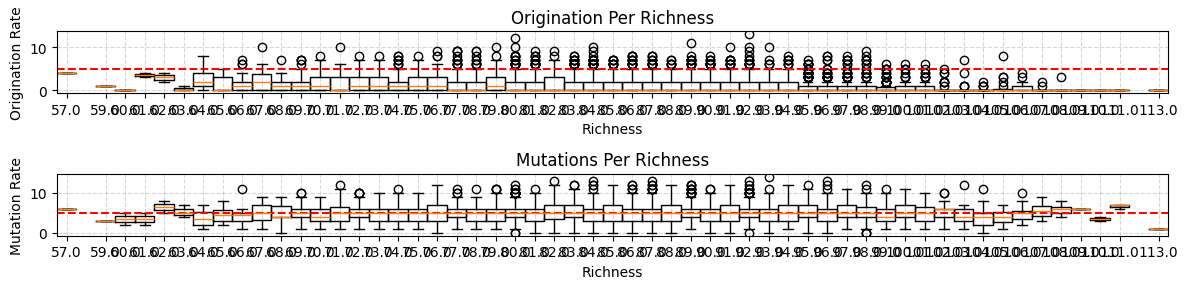

In [12]:
# Create the boxplot
fig, axs = plt.subplots(2,1,figsize=(12, 3))
mutation_p = 0.05
death_r = 100
# Create the boxplot with specified positions
axs[0].boxplot(
    ori_all_at_richness_1d,
    positions=richness_values,
    widths=1,
    showfliers=True  
)

axs[1].boxplot(
    mut_all_at_richness_1d,
    positions=richness_values,
    widths=1,
    showfliers=True  
)

# Set axis labels and title
axs[0].set_xlabel('Richness')
axs[0].set_ylabel('Origination Rate')
axs[0].set_title('Origination Per Richness')
axs[0].axhline(np.round(mutation_p * death_r,2), color='red', linestyle='dashed', label='Expected Mutation Rate')
axs[1].set_xlabel('Richness')
axs[1].set_ylabel('Mutation Rate')
axs[1].set_title('Mutations Per Richness')
axs[1].axhline(np.round(mutation_p * death_r,2), color='red', linestyle='dashed', label='Expected Mutation Rate')

# Improve layout
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Example with Second-for-Third

In [13]:
# Two-for-three extinction redefinition to get out proportional change
'''
def getExt2f3_V2(countsMat):
    # s1d, s2d, s3d
    sSubE = np.sort(countsMat[:,7:10], axis = 1)[:,1]
    # s1d, sSubE, t2d, tP
    ext2f3 = (countsMat[:,7] - sSubE) / (countsMat[:,1] + countsMat[:,4])
    ext2f3P = np.log(1 / (1 - ext2f3))
    return ext2f3P, ext2f3

# Two-for-three orgination
def getOrg2f3_V2(countsMat):
    # s1u, s2u, s3u
    sSubU = np.sort(countsMat[:,10:13], axis = 1)[:,1]
    # s1u, sSubU, t2u, tP
    ori2f3 = (countsMat[:,10] - sSubU) / (countsMat[:,2] + countsMat[:,4])
    ori2f3P = np.log(1 / (1 - ori2f3))
    return ori2f3P, ori2f3
'''

'\ndef getExt2f3_V2(countsMat):\n    # s1d, s2d, s3d\n    sSubE = np.sort(countsMat[:,7:10], axis = 1)[:,1]\n    # s1d, sSubE, t2d, tP\n    ext2f3 = (countsMat[:,7] - sSubE) / (countsMat[:,1] + countsMat[:,4])\n    ext2f3P = np.log(1 / (1 - ext2f3))\n    return ext2f3P, ext2f3\n\n# Two-for-three orgination\ndef getOrg2f3_V2(countsMat):\n    # s1u, s2u, s3u\n    sSubU = np.sort(countsMat[:,10:13], axis = 1)[:,1]\n    # s1u, sSubU, t2u, tP\n    ori2f3 = (countsMat[:,10] - sSubU) / (countsMat[:,2] + countsMat[:,4])\n    ori2f3P = np.log(1 / (1 - ori2f3))\n    return ori2f3P, ori2f3\n'

In [ ]:
# Simulate Example
mutation_p = 0.05
death_r = 10
model_n = 10000
cut = 2000
J = 1000
expanded_community = np.repeat(1,J)
untb_results, ancs, desc, n_muts = untbPython.untb_Hankin_Phylo_V2(expanded_community, mutation_probability= mutation_p, death_rate= death_r, generations=model_n, keep=False)


species_list_all = np.arange(1, np.max(untb_results)+1, dtype = np.int64)
set_num_threads(8) # Set thread number
spec_dyn = samplingFunctions.retrieve_species_dynamics_numba(untb_results, species_id = species_list_all)

# Bias the output
test_spec = np.array(spec_dyn.copy(), dtype=np.int64)
presence = test_spec[cut:] # Discard burn-in period

# Filter out time steps you will not observe
occ_list = diversityMetrics.convert_to_dictionary(presence)

# Diversity Metrics
# Diversity 
dynMat = divDynFunctions.binnedToExpandedFad(occ_list)
# Convert in matrix
metricMatrix = divDynFunctions.counts(dynMat)
# Diversity metrics
divRT = divDynFunctions.getdivRT(metricMatrix)

# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)

# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = org2f3[1:-1]
ext2f3 = ext2f3[1:-1]
divRT = divRT[1:-1]

prop_ori = divDynFunctions.getPropOri(metricMatrix)
prop_ext = divDynFunctions.getPropExt(metricMatrix)
prop_div = divDynFunctions.getdivRT(metricMatrix)

v_2f3 = np.array([divRT, org2f3, ext2f3])
richness_derived = np.unique(divRT)

ori_mean_derived = []
ext_mean_derived = []

for i in range(len(richness_derived)):
    rv = richness_derived[i]
    ori_mean_derived.append(np.mean(v_2f3[1, v_2f3[0,:] == rv]))
    ext_mean_derived.append(np.mean(v_2f3[2, v_2f3[0,:] == rv]))

oriM2_2f3 = [i for i in ori_mean_derived]
extM2_2f3 = [i for i in ext_mean_derived]

v_prop = np.array([prop_div, prop_ori, prop_ext])
richness_prop = np.unique(prop_div)

ori_mean_prop = []
ext_mean_prop = []

for i in range(len(richness_prop)):
    rv = richness_prop[i]
    ori_mean_prop.append(np.mean(v_prop[1, v_prop[0,:] == rv]))
    ext_mean_prop.append(np.mean(v_prop[2, v_prop[0,:] == rv]))

oriM2_prop = [i for i in ori_mean_prop]
extM2_prop = [i for i in ext_mean_prop]

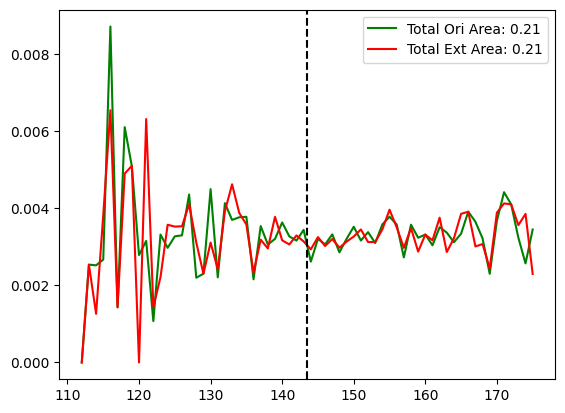

In [15]:
# Plot
fig, axs = plt.subplots(1,1)

oriM2_2f3_sum = np.sum(oriM2_2f3)
extM2_2f3_sum = np.sum(extM2_2f3)

axs.plot(richness_derived, oriM2_2f3, c = "green", label = f"Total Ori Area: {np.round(oriM2_2f3_sum,2)}")
axs.plot(richness_derived, extM2_2f3, c = "red", label = f"Total Ext Area: {np.round(extM2_2f3_sum,2)}")
axs.axvline(np.mean(richness_derived), c = "black", linestyle = "dashed")
axs.legend()